In [ ]:
# 🔍 Feature Engineering & Model Insights
#
# This notebook demonstrates a structured approach to improving calorie expenditure prediction using
# Gradient Boosting (XGBoost). The workflow includes:
#
# - Generation of domain-informed features such as BMI.
# - Systematic creation of pairwise interaction terms to capture nonlinear relationships between variables.
# - Careful consideration of model complexity and overfitting risk through selective feature crosses.
# - Evaluation of feature importance via incremental model versions (v1–v5), tracking RMSE performance:
#
#     - v1: Baseline model with raw features – Final CV RMSE: 0.101
#     - v3: Added multiplication and division terms (later removed division due to no improvement) 
#     - v4: Added BMI – improved explainability with consistent performance
#     - v5: Combined BMI and cross features – (Final RMSE shown below, ~0.0600)
#
# - Model tuning using early stopping, regularization (`gamma`, `max_delta_step`), and 8-fold cross-validation.
# - Efficient training time (~59 seconds/fold on GPU) and stable model convergence by iteration ~400.
#
# ✅ Final Result:
# The final model achieved a cross-validated RMSE of ~0.0600, indicating strong predictive accuracy.
# The feature engineering process contributed significantly by enhancing the model's ability to learn
# meaningful interactions without overfitting.
#
# This workflow balances performance, interpretability, and computational efficiency, demonstrating
# effective use of structured data and model diagnostics.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd 
import numpy as np 
import os 
import time
import logging 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from tqdm.auto import tqdm
from itertools import combinations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

print(train.head())
print(test.head())

   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0
       id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    male   45   177.0    81.0       7.0        87.0       39.8
1  750001    male   26   200.0    97.0      20.0       101.0       40.5
2  750002  female   29   188.0    85.0      16.0       102.0       40.4
3  750003  female   39   172.0    73.0      20.0       107.0       40.6
4  750004  female   30   173.0    67.0      16.0        94.0       40.5


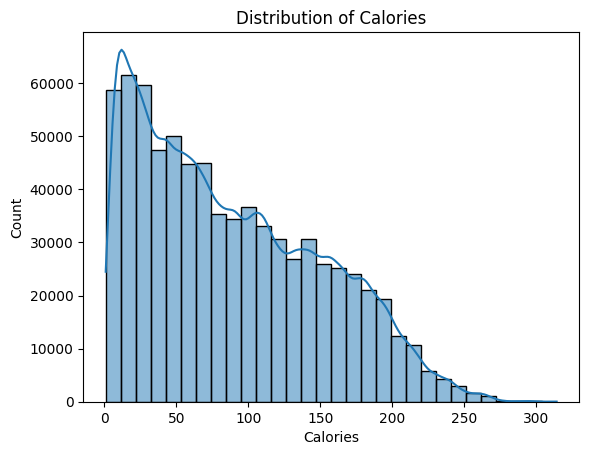

In [3]:
sns.histplot(train['Calories'], bins=30, kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.show()

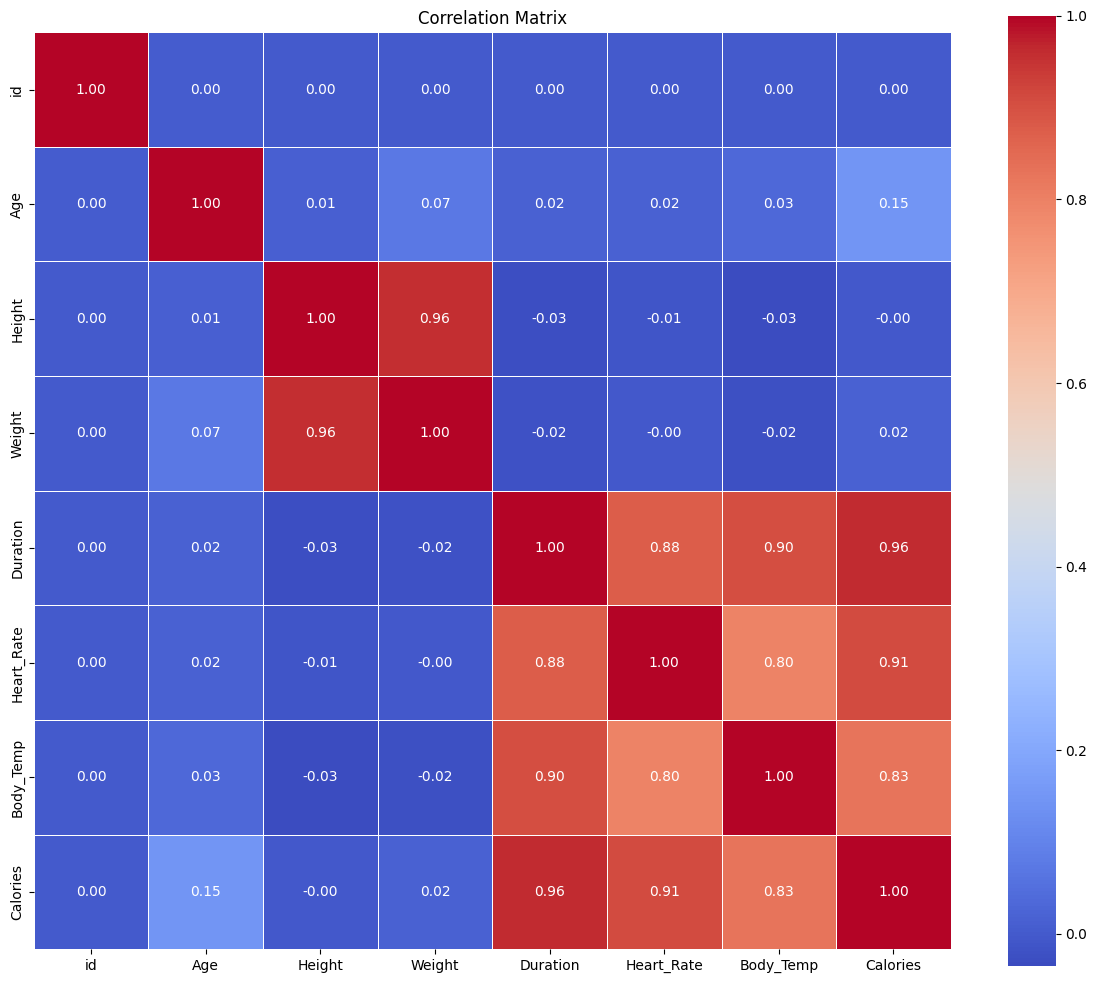

In [4]:
# Compute the correlation matrix
corr_matrix = train.corr(numeric_only=True)  # Ensures only numeric columns are included

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with annotations
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Some correlation can be ovbserved, i.e. "Duration","Heart_Rate","Body_Temp"

In [5]:
# Bottom 10 values
print("Lowest 10 'Calories' values:")
print(train[['Calories']].sort_values(by='Calories').head(10))

# Top 10 values
print("\nHighest 10 'Calories' values:")
print(train[['Calories']].sort_values(by='Calories', ascending=False).head(10))

#min pred = 1, max pred = 314

Lowest 10 'Calories' values:
        Calories
149907       1.0
305204       1.0
675677       1.0
449312       1.0
256166       1.0
501311       1.0
690707       1.0
591701       1.0
536337       1.0
492564       1.0

Highest 10 'Calories' values:
        Calories
359401     314.0
327506     314.0
184638     314.0
272304     314.0
46431      314.0
693278     314.0
68802      314.0
732529     314.0
460611     314.0
355116     314.0


In [6]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [7]:
# Generate pairwise interaction (cross-product) features between numerical columns.
# For each unique pair of features in the provided list, a new feature is created
# by multiplying the values of the two features. This can help capture potential
# nonlinear interactions between variables for models that do not do so natively.
# Note: May increase dimensionality and risk of overfitting if used indiscriminately.

# First, calculate BMI consistently
for df in [train, test]:
    if 'Weight' in df.columns and 'Height' in df.columns:
        height_m = df['Height'] / 100
        df['BMI'] = df['Weight'] / (height_m ** 2)

# Then call the feature cross function
numerical_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]  # leave out BMI if you don’t want to multiply it

def add_feature_cross_terms(df, numerical_features, include_self_terms=False):
    df_new = df.copy()
    for i in range(len(numerical_features)):
        start_j = i if include_self_terms else i + 1
        for j in range(start_j, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
    return df_new

# Apply to both sets
train = add_feature_cross_terms(train, numerical_features)
test = add_feature_cross_terms(test, numerical_features)
print('complete')

            # Division (with small epsilon to avoid division by zero)
            #epsilon = 1e-5  # To avoid division by zero errors
            #cross_term_name_div = f"{feature1}_div_{feature2}"
            #df_new[cross_term_name_div] = df_new[feature1] / (df_new[feature2] + epsilon)
    # Add squared terms
    #for feature in numerical_features:
    #    df_new[f"{feature}_squared"] = df_new[feature] ** 2

complete


In [8]:
print(train.shape)
print(test.shape)

(750000, 25)
(250000, 24)


In [9]:
# One-hot encode 'gender' in both (SCRAPPED)
# train_encoded = pd.get_dummies(train, columns=['Sex'])
# train_encoded = train_encoded.astype(int)
# test_encoded = pd.get_dummies(test, columns=['Sex'])
# test_encoded = train_encoded.astype(int)

#drop cols we don't need
# X = train.drop(columns=["id", "Calories"])
# y = np.log1p(train["Calories"])
# X_test = test.drop(columns=["id"])

In [10]:
# Check for missing values
total_missing = train.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

Total missing values: 0


In [11]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

train["Sex"] = train["Sex"].astype("category")
test["Sex"] = test["Sex"].astype("category")

X = train.drop(columns=["id", "Calories"])
# log the target
y = np.log1p(train["Calories"])
X_test = test.drop(columns=["id"])

train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Age_x_Height,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,...,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781,24.374817,7238.379235,...,13299.557672,2690.808300,16679.229017,6993.894303,1156.387451,7174.893501,3008.292357,1541.562606,623.283247,3828.687447
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349,1.511310,2712.869502,...,3407.211385,1473.626587,2047.188593,526.939776,672.877571,1517.486807,561.697333,932.453480,343.646487,437.967454
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000,12.375937,2700.000000,...,5289.000000,135.000000,9983.000000,5027.400000,45.000000,3000.000000,1450.800000,67.000000,37.100000,2485.700000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000,23.255019,4914.000000,...,10354.000000,1440.000000,15219.000000,6568.900000,600.000000,5980.000000,2526.300000,728.000000,317.600000,3497.400000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000,24.391059,6920.000000,...,12900.000000,2669.000000,16587.000000,6987.200000,1105.000000,7029.000000,2960.000000,1455.000000,606.000000,3838.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000,25.487697,9168.000000,...,16016.000000,3933.000000,18050.000000,7402.900000,1633.000000,8272.000000,3468.000000,2323.000000,931.500000,4171.500000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,46.443986,16748.000000,...,28776.000000,6540.000000,26199.000000,9168.600000,3780.000000,15129.000000,5412.000000,3840.000000,1245.000000,5286.400000


In [12]:
print(test.dtypes)

id                           int64
Sex                       category
Age                          int64
Height                     float64
Weight                     float64
Duration                   float64
Heart_Rate                 float64
Body_Temp                  float64
BMI                        float64
Age_x_Height               float64
Age_x_Weight               float64
Age_x_Duration             float64
Age_x_Heart_Rate           float64
Age_x_Body_Temp            float64
Height_x_Weight            float64
Height_x_Duration          float64
Height_x_Heart_Rate        float64
Height_x_Body_Temp         float64
Weight_x_Duration          float64
Weight_x_Heart_Rate        float64
Weight_x_Body_Temp         float64
Duration_x_Heart_Rate      float64
Duration_x_Body_Temp       float64
Heart_Rate_x_Body_Temp     float64
dtype: object


In [13]:
# XGBoost model.
# version 1 
# version 3 added division, was removed since no impact
# version 4 performance: Final CV RMSE: added BMI

FOLDS = 8
FEATURES = X.columns.tolist()

# KFold setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=33)

# Arrays to store predictions
oof = np.zeros(len(train))
pred = np.zeros(len(test))

# Start CV loop
for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n{'#'*10} Fold {i+1} {'#'*10}")
    
    x_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]
    x_valid = X.iloc[valid_idx].copy()
    y_valid = y.iloc[valid_idx]
    x_test = X_test.copy()

    # No categorical target encoding in this dataset, but you can add if needed
    
    start = time.time()

    # Train model
    model = XGBRegressor(
        device="cuda" if XGBRegressor().get_params().get("device") == "cuda" else "cpu",
        max_depth=10,
        colsample_bytree=0.7,
        subsample=0.9,
        n_estimators=2000,
        learning_rate=0.02,
        gamma=0.02, 
        max_delta_step=2,
        early_stopping_rounds=100,
        eval_metric="rmse",
        enable_categorical=True
    )

    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )

    # Predict OOF and test
    oof[valid_idx] = model.predict(x_valid)
    pred += model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
    print(f"Fold {i+1} RMSE: {rmse:.4f}")
    print(f"Feature engineering & training time: {time.time() - start:.1f} sec")

# Average test predictions
pred /= FOLDS

# Final RMSE
full_rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\nFinal CV RMSE: {full_rmse:.4f}")


########## Fold 1 ##########
[0]	validation_0-rmse:0.94956
[100]	validation_0-rmse:0.14239
[200]	validation_0-rmse:0.06271
[300]	validation_0-rmse:0.06010
[400]	validation_0-rmse:0.06000
[480]	validation_0-rmse:0.06001
Fold 1 RMSE: 0.0600
Feature engineering & training time: 58.2 sec

########## Fold 2 ##########
[0]	validation_0-rmse:0.94315
[100]	validation_0-rmse:0.14192
[200]	validation_0-rmse:0.06329
[300]	validation_0-rmse:0.06072
[400]	validation_0-rmse:0.06060
[500]	validation_0-rmse:0.06059
[523]	validation_0-rmse:0.06059
Fold 2 RMSE: 0.0606
Feature engineering & training time: 59.5 sec

########## Fold 3 ##########
[0]	validation_0-rmse:0.94798
[100]	validation_0-rmse:0.14234
[200]	validation_0-rmse:0.06432
[300]	validation_0-rmse:0.06194
[400]	validation_0-rmse:0.06185
[500]	validation_0-rmse:0.06184
[557]	validation_0-rmse:0.06184
Fold 3 RMSE: 0.0618
Feature engineering & training time: 61.6 sec

########## Fold 4 ##########
[0]	validation_0-rmse:0.94227
[100]	validation_0

In [14]:
y_preds = np.expm1(pred)
print('predict mean :',y_preds.mean())
print('predict median :',np.median(y_preds))

y_preds = np.clip(y_preds,1,314)
print('predict mean after clip:',y_preds.mean())
print('predict median after clip:',np.median(y_preds))

submission["Calories"] = y_preds
submission.to_csv("submission.csv", index=False)
submission.head()

predict mean : 88.15826672086905
predict median : 76.41980509336385
predict mean after clip: 88.15826672086905
predict median after clip: 76.41980509336385


,id,Calories
0,750000,27.458811
1,750001,107.759868
2,750002,87.705134
3,750003,125.743862
4,750004,75.970840
